# Summary

实验结果：

在 CIFAR10 数据集上的实验结果，使用 GPU GTX 1080.

| 模型 | epoch | training 正确率 | evaluate 正确率 | 运行时间 |
| -- | -- | -- | -- | -- |
| VggNet | 10 | 83% | 78% | 500s |
| ResNet-v1 | 10 | 85% | 79% | 168s |
| ResNet-v1 | 50 | 98% | 81% | 832s |

观点：

1. ResNet 的性能和能效比，都好于 VggNet。碾压式的进步。
2. 当前实现版本，过拟合很严重，是改进的重点。

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import time

tf.__version__

'2.1.0'

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train),(x_test, y_test) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

In [4]:
x_train.shape

(50000, 32, 32, 3)

In [5]:
def res_net_block(input_data, filters, conv_size):
    x = layers.Conv2D(filters, conv_size, activation='relu', padding='same')(input_data)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, conv_size, activation=None, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, input_data])
    x = layers.Activation('relu')(x)
    return x

In [6]:
N, W, H, C = x_train.shape
N_LABELS = 10

inputs = tf.keras.Input(shape=(W, H, C))
x = layers.Conv2D(32, 3, activation='relu')(inputs)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(3)(x)

num_res_net_blocks = 10
for i in range(num_res_net_blocks):
  x = res_net_block(x, 64, 3)

x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

In [7]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
print('!! start time counting')
tic = time.time()

history = model.fit(x_train, y_train, epochs=10, 
                    validation_data=(x_test, y_test))
model.evaluate(x_test, y_test, verbose=2)
toc = time.time()
print('!! Total timecost: %.2fs' % (toc - tic))

!! start time counting
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 19s 374us/sample - loss: 1.5674 - accuracy: 0.4223 - val_loss: 1.5674 - val_accuracy: 0.4666
Epoch 2/10
50000/50000 [==============================] - 16s 325us/sample - loss: 1.1001 - accuracy: 0.6105 - val_loss: 1.2281 - val_accuracy: 0.5751
Epoch 3/10
50000/50000 [==============================] - 16s 328us/sample - loss: 0.9012 - accuracy: 0.6846 - val_loss: 1.1706 - val_accuracy: 0.6232
Epoch 4/10
50000/50000 [==============================] - 16s 327us/sample - loss: 0.7796 - accuracy: 0.7327 - val_loss: 0.7812 - val_accuracy: 0.7318
Epoch 5/10
50000/50000 [==============================] - 16s 328us/sample - loss: 0.6879 - accuracy: 0.7663 - val_loss: 0.8449 - val_accuracy: 0.7233
Epoch 6/10
50000/50000 [==============================] - 17s 332us/sample - loss: 0.6190 - accuracy: 0.7883 - val_loss: 0.9080 - val_accuracy: 0.7120
Epoch 7/10
50000/5000

10000/10000 - 1s - loss: 0.6146 - accuracy: 0.7935
0.7935


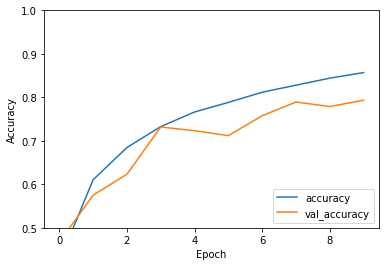

In [8]:
# train vs evaluate 的 accuracy 曲线
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(test_acc)

#### 50 epochs

In [9]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
print('!! start time counting')
tic = time.time()

history = model.fit(x_train, y_train, epochs=50, 
                    validation_data=(x_test, y_test))
model.evaluate(x_test, y_test, verbose=2)
toc = time.time()
print('!! Total timecost: %.2fs' % (toc - tic))

!! start time counting
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 18s 360us/sample - loss: 0.3818 - accuracy: 0.8690 - val_loss: 0.6767 - val_accuracy: 0.7866
Epoch 2/50
50000/50000 [==============================] - 16s 327us/sample - loss: 0.3441 - accuracy: 0.8819 - val_loss: 0.7574 - val_accuracy: 0.7688
Epoch 3/50
50000/50000 [==============================] - 16s 329us/sample - loss: 0.3119 - accuracy: 0.8916 - val_loss: 0.6382 - val_accuracy: 0.8082
Epoch 4/50
50000/50000 [==============================] - 16s 329us/sample - loss: 0.2857 - accuracy: 0.9026 - val_loss: 0.7626 - val_accuracy: 0.7885
Epoch 5/50
50000/50000 [==============================] - 16s 328us/sample - loss: 0.2629 - accuracy: 0.9085 - val_loss: 0.6869 - val_accuracy: 0.8024
Epoch 6/50
50000/50000 [==============================] - 17s 330us/sample - loss: 0.2337 - accuracy: 0.9199 - val_loss: 0.7261 - val_accuracy: 0.7912
Epoch 7/50
50000/5000

10000/10000 - 1s - loss: 1.1636 - accuracy: 0.8187
0.8187


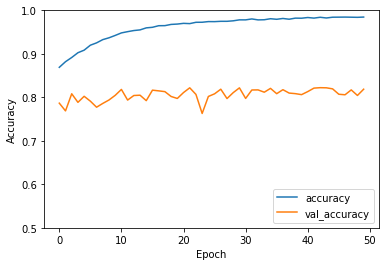

In [10]:
# train vs evaluate 的 accuracy 曲线
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(test_acc)